# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [ ]:
# Requirements
!pip install yahoo_fin

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.1 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=fbaa94759543e5a302bfa950fedab350bab4c4c3a51bc63decb92c0994d1a4d6
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3


In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [ ]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3, 4, 5]

# Stock ticker, GOOGL
STOCK = 'TM'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
ml76049p_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [ ]:
ml76049p_df.head()

,open,high,low,close,adjclose,volume,ticker
2021-11-30,33.168999,33.353001,31.864000,32.675999,32.617748,622066000,NVDA
2021-12-01,33.219002,33.289001,31.379999,31.434999,31.382801,484368000,NVDA
2021-12-02,31.214001,32.478001,31.025000,32.125999,32.072655,472890000,NVDA
2021-12-03,32.000000,32.129002,30.129999,30.693001,30.642036,544325000,NVDA
2021-12-06,29.879999,30.240999,28.038000,30.037001,29.987129,658938000,NVDA


In [ ]:
!date

Sun Dec  8 07:27:34 PM UTC 2024


In [ ]:
%connect_info

{
  "shell_port": 1,
  "iopub_port": 2,
  "stdin_port": 3,
  "control_port": 4,
  "hb_port": 5,
  "ip": "/root/.local/share/jupyter/runtime/kernel-d026b2fe-0fed-4471-b3b5-bf68a49f4e0d-ipc",
  "key": "",
  "transport": "ipc",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d026b2fe-0fed-4471-b3b5-bf68a49f4e0d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [ ]:
# remove columns which our neural network will not use
ml76049p_df = ml76049p_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
ml76049p_df['date'] = ml76049p_df.index

In [ ]:
ml76049p_df

,close,date
2021-11-30,32.675999,2021-11-30
2021-12-01,31.434999,2021-12-01
2021-12-02,32.125999,2021-12-02
2021-12-03,30.693001,2021-12-03
2021-12-06,30.037001,2021-12-06
...,...,...
2024-12-02,138.630005,2024-12-02
2024-12-03,140.259995,2024-12-03
2024-12-04,145.139999,2024-12-04
2024-12-05,145.059998,2024-12-05


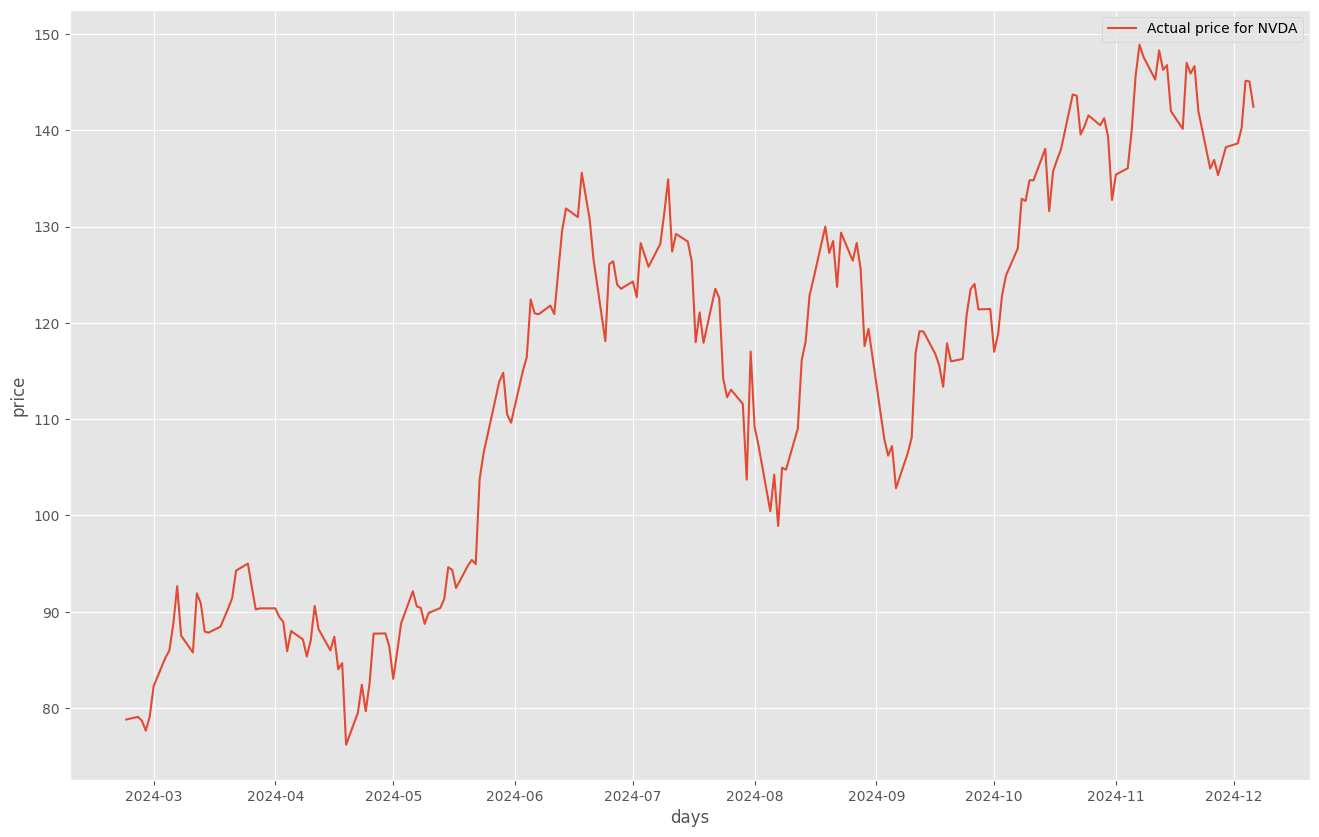

In [ ]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(xy12345n_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:
# Scale data for ML engine
scaler = MinMaxScaler()
ml76049p_df['scaled_close'] = scaler.fit_transform(np.expand_dims(xy12345n_df['close'].values, axis=1))

In [ ]:
ml76049p_df

,close,date,scaled_close
2021-11-30,32.675999,2021-11-30,0.155819
2021-12-01,31.434999,2021-12-01,0.146804
2021-12-02,32.125999,2021-12-02,0.151824
2021-12-03,30.693001,2021-12-03,0.141414
2021-12-06,30.037001,2021-12-06,0.136648
...,...,...,...
2024-12-02,138.630005,2024-12-02,0.925537
2024-12-03,140.259995,2024-12-03,0.937379
2024-12-04,145.139999,2024-12-04,0.972830
2024-12-05,145.059998,2024-12-05,0.972249


In [ ]:
def PrepareData(days):
  df = ml76049p_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2021-11-30   32.675999 2021-11-30      0.155819  0.141414
 2021-12-01   31.434999 2021-12-01      0.146804  0.136648
 2021-12-02   32.125999 2021-12-02      0.151824  0.154010
 2021-12-03   30.693001 2021-12-03      0.141414  0.149644
 2021-12-06   30.037001 2021-12-06      0.136648  0.139939
 ...                ...        ...           ...       ...
 2024-11-26  136.919998 2024-11-26      0.913115  0.925537
 2024-11-27  135.339996 2024-11-27      0.901637  0.937379
 2024-11-29  138.250000 2024-11-29      0.922777  0.972830
 2024-12-02  138.630005 2024-12-02      0.925537  0.972249
 2024-12-03  140.259995 2024-12-03      0.937379  0.953216
 
 [757 rows x 4 columns],
 array([[0.94965595],
        [0.9065767 ],
        [0.9131148 ],
        [0.90163666],
        [0.9227768 ],
        [0.9255374 ],
        [0.9373787 ],
        [0.9728302 ],
        [0.97224903],
        [0.95321566]], dtype=float32),
 array([[[0.1558193263296068

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0336
Epoch 2/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037
Epoch 3/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031
Epoch 4/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039
Epoch 5/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023
Epoch 6/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019
Epoch 7/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026
Epoch 8/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 9/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 10/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 11/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 12/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0040
Epoch 13/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 14/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018
Epoch 15/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 16/80
95/95 ━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0193
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0336
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0367
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0180
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 5 days ({predictions_str})'

  print(message)

NVDA prediction for upcoming 5 days (134.31$, 141.14$, 144.33$, 139.09$, 136.98$)


In [ ]:
# Execute model for the whole history range
copy_ml76049p_df = ml76049p_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
#Adjust the lengths of first_seq and last_seq to ensure they sum to the correct length
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:N_STEPS], axis=1)) # Changed to N_STEPS
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-(len(ml76049p_df) - len(y_predicted_transformed) - len(first_seq)):], axis=1)) # Dynamically calculated length
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)

# Check if lengths match before assignment
if len(y_predicted_transformed) != len(copy_ml76049p_df):
    print(f"Warning: Length mismatch! Predicted: {len(y_predicted_transformed)}, DataFrame: {len(copy_ml76049p_df)}")
    # Handle the length mismatch (e.g., truncate or pad) before assignment

# Now assign the predicted values
copy_ml76049p_df[f'predicted_close'] = y_predicted_transformed

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
copy_ml76049p_df

,close,date,scaled_close,predicted_close
2021-11-30,32.675999,2021-11-30,0.155819,30.459000
2021-12-01,31.434999,2021-12-01,0.146804,28.386999
2021-12-02,32.125999,2021-12-02,0.151824,27.801001
2021-12-03,30.693001,2021-12-03,0.141414,27.719000
2021-12-06,30.037001,2021-12-06,0.136648,29.075001
...,...,...,...,...
2024-12-02,138.630005,2024-12-02,0.925537,133.412766
2024-12-03,140.259995,2024-12-03,0.937379,140.259995
2024-12-04,145.139999,2024-12-04,0.972830,145.139999
2024-12-05,145.059998,2024-12-05,0.972249,145.059998


In [ ]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_ml76049p_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_ml76049p_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_ml76049p_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

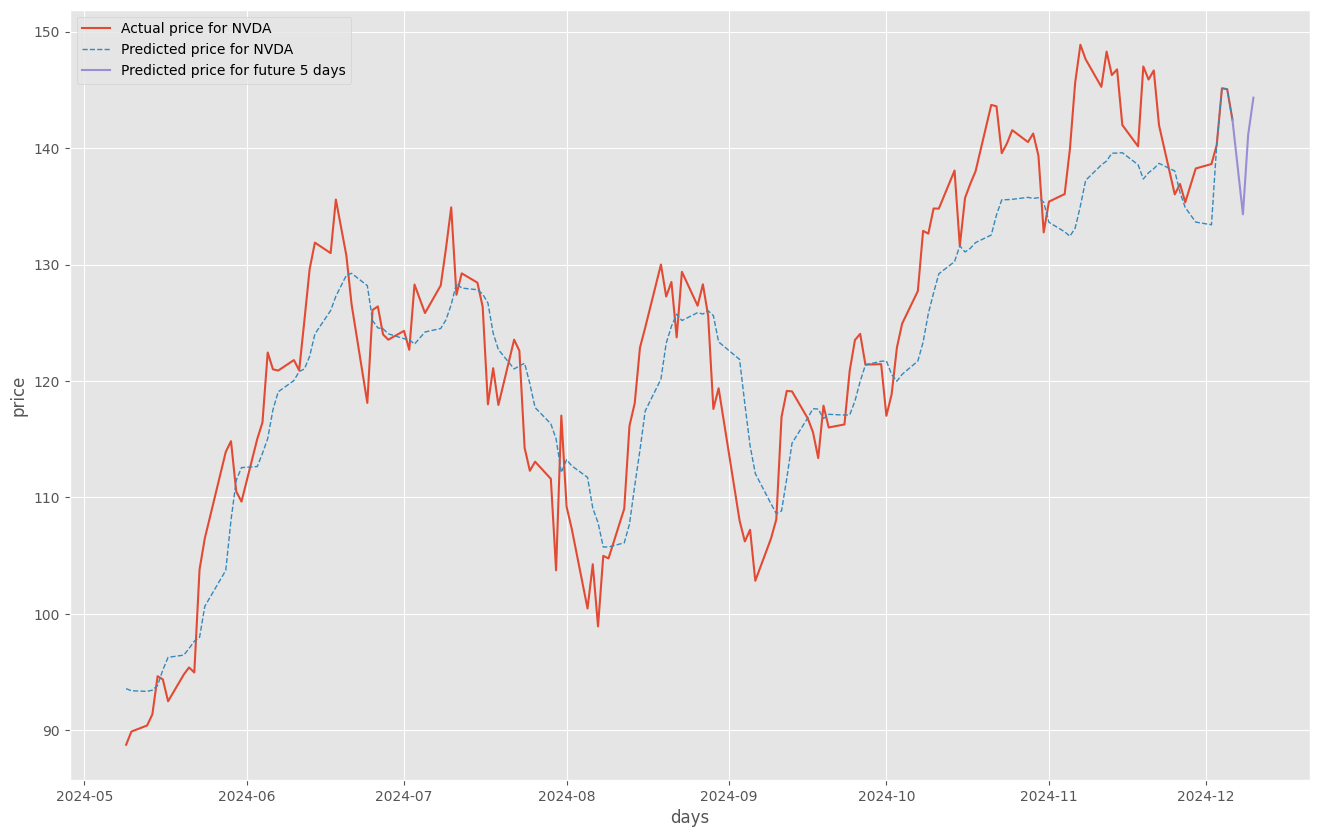

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_ml76049p_df['close'][-150:].head(147))
plt.plot(copy_ml76049p_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_ml76049p_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 5 days'])
plt.show()